In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.sample import sample_gen
import rasterio.plot

from shapely.geometry import Point, box, Polygon

from sklearn.svm import OneClassSVM, SVC
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb

from skimage.transform import resize

In [114]:

# Add persence point file file path

# Raw points 
pfile = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/commodity_crops/raw_points/Carrots.csv"

#creates a pandas df
def create_df(file):
    df = pd.read_csv(file)
    return df

presences = create_df(pfile)

In [115]:
presences

,OID_,pointid,grid_code,POINT_X,POINT_Y
0,0,1,206,-120.017765,41.172144
1,1,2,206,-120.018012,41.170713
2,2,3,206,-120.018932,41.158360
3,3,4,206,-120.169580,40.107293
4,4,5,206,-120.044052,39.956218
...,...,...,...,...,...
111968,111968,111969,206,-115.322065,32.680115
111969,111969,111970,206,-115.324521,32.679417
111970,111970,111971,206,-115.324706,32.678836
111971,111971,111972,206,-115.324956,32.678518


In [116]:
presences.drop(columns=['OID_','pointid', 'grid_code'], inplace=True)
# presences.drop(columns=['OID_','Species'], inplace=True)

In [117]:
presences.rename(columns={'POINT_X':'Longitude','POINT_Y':'Latitude'}, inplace=True)

In [118]:
def clip_raster_to_california(raster_path, output_path, california_boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, [california_boundary], crop=True)
        out_meta = src.meta.copy()

        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [119]:
california_counties = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson')
california_boundary = california_counties.unary_union

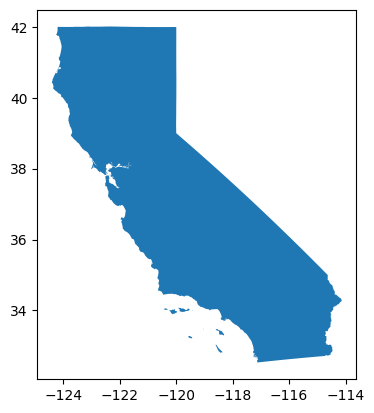

In [120]:
california_boundary_gdf = gpd.GeoDataFrame(geometry=[california_boundary], crs=california_counties.crs)

# Plotting
california_boundary_gdf.plot()
plt.show()

In [121]:
print(california_counties.crs)

EPSG:4326


### Generating dummy lat long values - Testing

# **Implemenation Start**

# `Incorporating Presence Points with Bioclimatic Data`

In [122]:
# Path to raster file
raster_file = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/bioclims/californiaclipped/bio_1.tif'

# print raster files CRS
with rasterio.open(raster_file) as src:
    print(src.crs)


EPSG:4326


In [123]:
with rasterio.open(raster_file) as src:
    print(src.bounds)  # bounding box of the raster


BoundingBox(left=-124.41680577785002, bottom=32.49986062115002, right=-114.12513915235002, top=41.99986058315002)


In [124]:
# min_lon, min_lat = -124.409591, 32.534156
# max_lon, max_lat = -114.131211, 42.009518

In [125]:
with rasterio.open(raster_file) as src:
    print(src.nodata)  # NoData value set in the raster


-32768.0


In [126]:
points = [(-121.819467, 38.976219), (-122.875284, 38.672470)]  # Sample points

with rasterio.open(raster_file) as src:
    for val in src.sample(points):
        print(val)  # testing raster value at each point


[177]
[150]


In [127]:
def sample_raster_values(raster_path, presence_points):
    """
    Samples raster values at each coordinate in a Pandas dataframe.
    
    Parameters:
    -----------
    raster_path : str
        The path to the raster file.
    presence_points : pandas.DataFrame
        A Pandas dataframe with columns 'Longitude' and 'Latitude' containing the coordinates to sample.
        
    Returns:
    --------
    pandas.DataFrame
        A new Pandas dataframe with columns for each raster band containing the sampled values.
    """
    # Created an empty dataframe with the same index as presence_points
    bio_df = pd.DataFrame(index=presence_points.index)

    # Looped over each raster file
    for i in range(1, 20):
        filename = f'{raster_path}/bio_{i}.tif'

        # Opened the raster file
        with rasterio.open(filename) as src:

            # Sampled the raster at each coordinate in the dataframe
            values = []
            for idx, row in presence_points.iterrows():
                lon, lat = row['Longitude'], row['Latitude']
                result = list(src.sample([(lon, lat)]))

                # Extracted the first and only value from the result if it's not None
                if result[0] is not None:
                    # Assuming result[0] is a one-element array,
                    values.append(int(result[0][0]))  # first element of the array
                else:
                    values.append('NA')


            # Added the values to the dataframe
            bio_df[f'bio_{i}'] = values
    
    return bio_df


In [128]:
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped'

In [129]:
# Empty df to store bio climatic variables
# bio_df.columns

In [130]:
presence_bio_df = sample_raster_values(raster_path, presences)

In [131]:
presence_bio_df = pd.concat([presences,presence_bio_df],axis=1) #pp+bio

In [132]:
presence_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-120.017765,41.172144,104,116,32,8215,314,-46,360,9,...,228,-1,199,24,5,38,71,17,17,71
1,-120.018012,41.170713,104,116,32,8215,314,-46,360,9,...,228,-1,199,24,5,38,71,17,17,71
2,-120.018932,41.158360,95,116,32,8147,304,-54,358,16,...,218,-9,211,25,5,36,73,18,18,71
3,-120.169580,40.107293,113,121,33,8008,318,-41,360,9,...,232,9,264,47,5,59,134,17,17,134
4,-120.044052,39.956218,95,122,34,7902,298,-59,357,-7,...,212,-7,286,53,6,61,150,19,19,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,-115.322065,32.680115,247,137,40,7028,430,92,338,154,...,348,154,66,10,0,59,28,1,22,28
111969,-115.324521,32.679417,247,137,40,7028,430,92,338,154,...,348,154,66,10,0,59,28,1,22,28
111970,-115.324706,32.678836,247,137,40,7028,430,92,338,154,...,348,154,66,10,0,59,28,1,22,28
111971,-115.324956,32.678518,247,137,40,7028,430,92,338,154,...,348,154,66,10,0,59,28,1,22,28


In [133]:
# presence_bio_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/pres_bio_df.csv',index=False)

presence_bio_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/pres_bio_df.csv',index=False)

In [134]:
# presence_bio_df = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/2010-2100/final_avg/final_avg_4046.csv')
# presence_bio_df.rename(columns={'POINT_X':'Longitude','POINT_Y':'Latitude'}, inplace=True)

In [135]:
# presence_bio_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/future_avg/2040_46/tomato/pres_bio_df.csv',index=False)

# `OCSVM - Pseudoabsence data generation `

In [136]:
# -3.4e38 is the NoData value
no_data_value = -32768
presence_bio_df.replace(no_data_value, np.nan, inplace=True)

In [137]:
presence_bio_df.isnull().sum()

Longitude    0
Latitude     0
bio_1        0
bio_2        0
bio_3        0
bio_4        0
bio_5        0
bio_6        0
bio_7        0
bio_8        0
bio_9        0
bio_10       0
bio_11       0
bio_12       0
bio_13       0
bio_14       0
bio_15       0
bio_16       0
bio_17       0
bio_18       0
bio_19       0
dtype: int64

In [138]:
presence_bio_df.dropna(inplace=True)

In [139]:
presence_bio_df.iloc[:, 2:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
1,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
2,95,116,32,8147,304,-54,358,16,218,218,-9,211,25,5,36,73,18,18,71
3,113,121,33,8008,318,-41,360,9,232,232,9,264,47,5,59,134,17,17,134
4,95,122,34,7902,298,-59,357,-7,212,212,-7,286,53,6,61,150,19,19,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111969,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111970,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111971,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28


In [140]:
# Normalized the data to feed ocsvm
X = presence_bio_df.iloc[:,2:].values

# Standardized the bioclimatic data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [141]:
nu_s=[0.01,0.05,0.1,0.5] # hyperparameter

# Train OCSVM model using presence data nu=0.01
ocsvm_m1 = OneClassSVM(nu=nu_s[0])
ocsvm_m1.fit(X)

# Train OCSVM model using presence data nu=0.05
ocsvm_m2 = OneClassSVM(nu=nu_s[1])
ocsvm_m2.fit(X)

# Train OCSVM model using presence data nu=0.1
ocsvm_m3 = OneClassSVM(nu=nu_s[2])
ocsvm_m3.fit(X)

ocsvm_m4 = OneClassSVM(nu=nu_s[3])
ocsvm_m4.fit(X)

OneClassSVM()

In [142]:
def generate_pseudoabsences(polygon, n_pseudoabsences):
    """
    Generates pseudoabsence points within a polygon.
    
    Parameters:
    -----------
    polygon : shapely.geometry.Polygon
        The polygon in which to generate the pseudoabsences.
    n_pseudoabsences : int
        The number of pseudoabsences to generate.
        
    Returns:
    --------
    list
        A list of tuples, where each tuple contains the x and y coordinates of a pseudoabsence point.
    """
    # Defined the extent of the polygon
    min_x, min_y, max_x, max_y = polygon.bounds

    # Generated the pseudoabsences
    pseudoabsences = []
    while len(pseudoabsences) < n_pseudoabsences:
        # Generated a random point within the extent of the polygon
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        point = Point(x, y)

        # Checked if the point is within the polygon
        if polygon.contains(point):
            pseudoabsences.append((x, y))
    
    return pseudoabsences

In [161]:
# Bounding box coordinates for entire California
min_lon, min_lat = -124.409591, 32.534156
max_lon, max_lat = -114.131211, 42.009518

# Created a polygon using the bounding box coordinates
cali_sm2_loc = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

pseudoabsences = generate_pseudoabsences(cali_sm2_loc,n_pseudoabsences=160000)

In [162]:
# pseudoabsences

In [163]:
# Created a df containing pseudoabs+biovars
pseudoabsences_df = pd.DataFrame({'Longitude': [x[0] for x in pseudoabsences],
                                  'Latitude': [x[1] for x in pseudoabsences]})


In [164]:
pseudoabsences_df

,Longitude,Latitude
0,-120.882599,35.297187
1,-123.012075,32.547977
2,-115.898096,41.190989
3,-118.081604,36.461576
4,-114.474904,36.022790
...,...,...
159995,-116.008169,34.365631
159996,-118.664686,33.049050
159997,-114.769297,37.021529
159998,-123.270202,39.596843


In [165]:
# Incorporating background points with bio climatic raster data 
pseudoabsences_bio_df=sample_raster_values(raster_path,pseudoabsences_df)
pseudoabsences_bio_df=pd.concat([pseudoabsences_df,pseudoabsences_bio_df],axis=1)

In [166]:
pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-120.882599,35.297187,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1,-123.012075,32.547977,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
2,-115.898096,41.190989,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
3,-118.081604,36.461576,135,117,34,7894,324,-19,343,37,...,249,33,202,43,2,83,120,10,12,119
4,-114.474904,36.022790,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-116.008169,34.365631,183,133,38,7453,371,24,347,84,...,289,84,114,16,1,53,47,4,39,47
159996,-118.664686,33.049050,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
159997,-114.769297,37.021529,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
159998,-123.270202,39.596843,109,102,40,5034,254,4,250,43,...,181,43,1360,256,2,83,754,15,21,754


In [167]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.dropna()

pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
3,-118.081604,36.461576,135.0,117,34,7894.0,324.0,-19.0,343.0,37.0,...,249.0,33.0,202.0,43.0,2.0,83.0,120.0,10.0,12.0,119.0
5,-120.210937,37.332060,185.0,125,40,6093.0,359.0,52.0,307.0,111.0,...,273.0,105.0,405.0,73.0,1.0,83.0,215.0,3.0,3.0,214.0
7,-115.587291,34.095848,215.0,132,37,7537.0,403.0,55.0,348.0,115.0,...,323.0,115.0,99.0,15.0,1.0,51.0,42.0,4.0,31.0,42.0
10,-120.026086,36.349675,186.0,133,42,6048.0,361.0,47.0,313.0,117.0,...,273.0,106.0,193.0,39.0,0.0,84.0,109.0,1.0,1.0,106.0
13,-119.462640,37.559361,51.0,122,38,6531.0,228.0,-86.0,314.0,-28.0,...,148.0,-30.0,1027.0,211.0,5.0,84.0,585.0,18.0,18.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159984,-122.185734,39.278456,176.0,122,39,6364.0,356.0,45.0,310.0,91.0,...,265.0,91.0,480.0,95.0,1.0,85.0,274.0,5.0,5.0,274.0
159987,-123.338526,39.523718,113.0,95,40,4712.0,249.0,14.0,234.0,51.0,...,180.0,51.0,1475.0,304.0,2.0,88.0,880.0,13.0,20.0,880.0
159993,-120.437265,37.578513,182.0,124,41,5978.0,353.0,51.0,302.0,103.0,...,268.0,103.0,459.0,91.0,1.0,86.0,262.0,3.0,3.0,262.0
159995,-116.008169,34.365631,183.0,133,38,7453.0,371.0,24.0,347.0,84.0,...,289.0,84.0,114.0,16.0,1.0,53.0,47.0,4.0,39.0,47.0


In [168]:
pseudoabsences_bio_df.iloc[:, 2:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
3,135.0,117,34,7894.0,324.0,-19.0,343.0,37.0,232.0,249.0,33.0,202.0,43.0,2.0,83.0,120.0,10.0,12.0,119.0
5,185.0,125,40,6093.0,359.0,52.0,307.0,111.0,273.0,273.0,105.0,405.0,73.0,1.0,83.0,215.0,3.0,3.0,214.0
7,215.0,132,37,7537.0,403.0,55.0,348.0,115.0,277.0,323.0,115.0,99.0,15.0,1.0,51.0,42.0,4.0,31.0,42.0
10,186.0,133,42,6048.0,361.0,47.0,313.0,117.0,267.0,273.0,106.0,193.0,39.0,0.0,84.0,109.0,1.0,1.0,106.0
13,51.0,122,38,6531.0,228.0,-86.0,314.0,-28.0,148.0,148.0,-30.0,1027.0,211.0,5.0,84.0,585.0,18.0,18.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159984,176.0,122,39,6364.0,356.0,45.0,310.0,91.0,265.0,265.0,91.0,480.0,95.0,1.0,85.0,274.0,5.0,5.0,274.0
159987,113.0,95,40,4712.0,249.0,14.0,234.0,51.0,174.0,180.0,51.0,1475.0,304.0,2.0,88.0,880.0,13.0,20.0,880.0
159993,182.0,124,41,5978.0,353.0,51.0,302.0,103.0,268.0,268.0,103.0,459.0,91.0,1.0,86.0,262.0,3.0,3.0,262.0
159995,183.0,133,38,7453.0,371.0,24.0,347.0,84.0,243.0,289.0,84.0,114.0,16.0,1.0,53.0,47.0,4.0,39.0,47.0


In [169]:
# Extract only bioclimatic data for the presence points
x = pseudoabsences_bio_df.iloc[:, 2:].values

# Standardize the bioclimatic data
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [170]:
# suitable points (1) unsuitable (-1)
pseudo_absences_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == -1] #0.01

pseudo_absences_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == -1] #0.05

pseudo_absences_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == -1] #0.1

pseudo_absences_m4 = pseudoabsences_bio_df.loc[ocsvm_m4.predict(x) == -1] #0.1

In [171]:
# print("Unsuitable points detected with ocsvm model 1 with nu = 0.01 :", pseudo_absences_m1.shape[0])
# print("Unsuitable points detected with ocsvm model 2 with nu = 0.05 :", pseudo_absences_m2.shape[0])
print("Unsuitable points detected with ocsvm model 3 with nu = 0.1 :", pseudo_absences_m3.shape[0])
print("Unsuitable points detected with ocsvm model 4 with nu = 0.5 :", pseudo_absences_m4.shape[0])

Unsuitable points detected with ocsvm model 3 with nu = 0.1 : 69226
Unsuitable points detected with ocsvm model 4 with nu = 0.5 : 69271


In [172]:
pseudo_absences_m4

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
3,-118.081604,36.461576,135.0,117,34,7894.0,324.0,-19.0,343.0,37.0,...,249.0,33.0,202.0,43.0,2.0,83.0,120.0,10.0,12.0,119.0
5,-120.210937,37.332060,185.0,125,40,6093.0,359.0,52.0,307.0,111.0,...,273.0,105.0,405.0,73.0,1.0,83.0,215.0,3.0,3.0,214.0
7,-115.587291,34.095848,215.0,132,37,7537.0,403.0,55.0,348.0,115.0,...,323.0,115.0,99.0,15.0,1.0,51.0,42.0,4.0,31.0,42.0
10,-120.026086,36.349675,186.0,133,42,6048.0,361.0,47.0,313.0,117.0,...,273.0,106.0,193.0,39.0,0.0,84.0,109.0,1.0,1.0,106.0
13,-119.462640,37.559361,51.0,122,38,6531.0,228.0,-86.0,314.0,-28.0,...,148.0,-30.0,1027.0,211.0,5.0,84.0,585.0,18.0,18.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159984,-122.185734,39.278456,176.0,122,39,6364.0,356.0,45.0,310.0,91.0,...,265.0,91.0,480.0,95.0,1.0,85.0,274.0,5.0,5.0,274.0
159987,-123.338526,39.523718,113.0,95,40,4712.0,249.0,14.0,234.0,51.0,...,180.0,51.0,1475.0,304.0,2.0,88.0,880.0,13.0,20.0,880.0
159993,-120.437265,37.578513,182.0,124,41,5978.0,353.0,51.0,302.0,103.0,...,268.0,103.0,459.0,91.0,1.0,86.0,262.0,3.0,3.0,262.0
159995,-116.008169,34.365631,183.0,133,38,7453.0,371.0,24.0,347.0,84.0,...,289.0,84.0,114.0,16.0,1.0,53.0,47.0,4.0,39.0,47.0


In [173]:
# pseudo_absences_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/unsuitable_ocsvm_m3.csv',index=False)
# pseudo_absences_m4.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/unsuitable_ocsvm_m4.csv',index=False)

pseudo_absences_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/unsuitable_ocsvm_m3.csv',index=False)
pseudo_absences_m4.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/unsuitable_ocsvm_m4.csv',index=False)

In [174]:
pseudo_absences_m4 = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/unsuitable_ocsvm_m4.csv')
pseudo_absences_m4['presence'] = 0

In [175]:
pre_pseu_ocsvm = pd.concat([presence_bio_df, pseudo_absences_m4])

In [176]:
pre_pseu_ocsvm.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/pre_pseu_ocsvm_scaled.csv')

In [177]:
# suitable points (1) unsuitable (-1)
suitable_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == 1]
suitable_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == 1]
suitable_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == 1]

print("Suitable points detected with ocsvm model 1 with nu = 0.01 :", suitable_m1.shape[0])
print("Suitable points detected with ocsvm model 2 with nu = 0.05 :", suitable_m2.shape[0])
print("Suitable points detected with ocsvm model 3 with nu = 0.1 :", suitable_m3.shape[0])

Suitable points detected with ocsvm model 1 with nu = 0.01 : 1902
Suitable points detected with ocsvm model 2 with nu = 0.05 : 171
Suitable points detected with ocsvm model 3 with nu = 0.1 : 45


In [178]:
suitable_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/suitable_ocsvm_m3.csv',index=False)

***

# `New Pseudoabsence Generation Method`

In [204]:
# Loaded bioclimatic variables data
bioclim_data = []
for i in range(1, 20):
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Masked out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

env_data = np.stack(bioclim_data, axis=2)
env_data

masked_array(
  data=[[[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  6

In [205]:
def generate_target_background(presence_points_df, study_area, n_samples=1000):
    # Presence points are in GeoDataFrame format
    if not isinstance(presence_points_df, gpd.GeoDataFrame):
        # Converting to GeoDataFrame assuming 'Longitude' and 'Latitude' columns
        presence_points_df = gpd.GeoDataFrame(
            presence_points_df, 
            geometry=gpd.points_from_xy(presence_points_df.Longitude, presence_points_df.Latitude)
        )

    background_points = []
    minx, miny, maxx, maxy = study_area.bounds  # Unpacking the bounds directly

    while len(background_points) < n_samples:
        # Randomly generated a point within the extent of the study area
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)

        # Ensured the point is not in any presence points and is within the study area
        if study_area.contains(point) and not presence_points_df.contains(point).any():
            background_points.append((x, y))

    # Convert -> DataFrame -> GeoDataFrame
    background_points_df = pd.DataFrame(background_points, columns=['Longitude', 'Latitude'])
    return gpd.GeoDataFrame(background_points_df, geometry=gpd.points_from_xy(background_points_df.Longitude, background_points_df.Latitude))


In [206]:
# Defined the bounding box coordinates for California
california_bounds = (-124.409591, 32.534156, -114.131211, 42.009518)
california_polygon = Polygon([(california_bounds[0], california_bounds[1]), 
                              (california_bounds[0], california_bounds[3]), 
                              (california_bounds[2], california_bounds[3]), 
                              (california_bounds[2], california_bounds[1])])

# Generateed background points
background_points = generate_target_background(presences, california_polygon, n_samples=160000)

In [207]:
background_points

,Longitude,Latitude,geometry
0,-122.854027,39.666931,POINT (-122.85403 39.66693)
1,-115.517886,39.462453,POINT (-115.51789 39.46245)
2,-116.568188,32.678343,POINT (-116.56819 32.67834)
3,-115.951591,38.522125,POINT (-115.95159 38.52212)
4,-116.849184,32.887330,POINT (-116.84918 32.88733)
...,...,...,...
159995,-116.416418,34.593264,POINT (-116.41642 34.59326)
159996,-120.614466,35.250731,POINT (-120.61447 35.25073)
159997,-116.479514,37.762153,POINT (-116.47951 37.76215)
159998,-117.639878,41.881832,POINT (-117.63988 41.88183)


In [208]:
# background_points.rename(columns={'POINT_X':'Longitude','POINT_Y':'Latitude'}, inplace=True)

In [209]:
# background_points.to_csv("/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/background_points.csv",index=False)

background_points.to_csv("/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/background_points.csv",index=False)

In [210]:
# averaging for future bioclimatic data 

def automate_bioclimatic_averaging(raster_base_path, presence_points_path, start_year, end_year):
    presences = pd.read_csv(presence_points_path)
    yearly_dataframes = []

    for year in range(start_year, end_year + 1):
        bio_df = pd.DataFrame(index=presences.index)

        for i in range(1, 20):
            bio_code = f'bio{str(i).zfill(2)}'
            filename = f'{raster_base_path}/{bio_code}_equiv_{year}_CA.tiff'
            with rasterio.open(filename) as src:
                values = [next(src.sample([(row['Longitude'], row['Latitude'])]))[0] if src.sample([(row['Longitude'], row['Latitude'])]) else np.nan for idx, row in presences.iterrows()]
                # Use consistent column names without the year suffix
                bio_df[f'{bio_code}'] = values

        # Add Longitude and Latitude to the DataFrame
        bio_df[['Longitude', 'Latitude']] = presences[['Longitude', 'Latitude']]
        yearly_dataframes.append(bio_df)

    # Concatenate the yearly DataFrames
    concatenated_df = pd.concat(yearly_dataframes)

    # Replace -9999 with NaN
    concatenated_df.replace(-9999, np.nan, inplace=True)

    # Drop NaN values 
    concatenated_df.dropna(inplace=True)

    # Group by Longitude and Latitude, and calculate the mean for each group
    averaged_df = concatenated_df.groupby(['Longitude', 'Latitude']).mean().reset_index()

    return averaged_df


In [211]:
# # Set parameters
# raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/2010-2100/2040_43'
# background_points_path = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/future_avg/2040_46/tomato/background_points.csv"
# start_year = 2040
# end_year = 2046

# # Call the function
# final_averaged_df = automate_bioclimatic_averaging(raster_path, background_points_path, start_year, end_year)

# rename_dict = {f'bio{str(i).zfill(2)}': f'bio_{i}' for i in range(1, 20)}

# final_averaged_df.rename(columns=rename_dict, inplace=True)
# final_averaged_df

In [212]:
# pseudoabsences_bio_df2 = final_averaged_df.copy()

In [213]:
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped'

In [214]:
pseudoabsences_bio_df2=sample_raster_values(raster_path,background_points[['Longitude','Latitude']])
pseudoabsences_bio_df2

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,62,115,40,5636,227,-55,283,-11,142,142,-11,993,200,3,81,564,17,17,564
1,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
2,149,122,45,5031,297,28,268,102,197,224,86,439,86,2,83,249,16,29,226
3,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
4,177,113,44,4728,316,63,252,131,234,248,118,419,80,2,86,234,7,12,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,184,132,37,7559,374,23,350,83,245,292,83,129,19,1,55,57,4,32,57
159996,153,104,46,4033,275,50,224,106,208,210,99,566,119,0,92,343,2,2,327
159997,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
159998,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535


In [215]:
pseudoabsences_bio_df2=pd.concat([background_points[['Longitude','Latitude']],pseudoabsences_bio_df2],axis=1)

In [216]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,62,115,40,5636,227,-55,283,-11,...,142,-11,993,200,3,81,564,17,17,564
1,-115.517886,39.462453,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
2,-116.568188,32.678343,149,122,45,5031,297,28,268,102,...,224,86,439,86,2,83,249,16,29,226
3,-115.951591,38.522125,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
4,-116.849184,32.887330,177,113,44,4728,316,63,252,131,...,248,118,419,80,2,86,234,7,12,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-116.416418,34.593264,184,132,37,7559,374,23,350,83,...,292,83,129,19,1,55,57,4,32,57
159996,-120.614466,35.250731,153,104,46,4033,275,50,224,106,...,210,99,566,119,0,92,343,2,2,327
159997,-116.479514,37.762153,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
159998,-117.639878,41.881832,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535


In [217]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.dropna()

pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,...,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,-116.568188,32.678343,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,...,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,-116.849184,32.887330,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,...,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,-120.085036,34.474503,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,...,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,-116.203113,32.654458,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,...,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [218]:
presence_bio_df['presence']=1
pseudoabsences_bio_df2['presence']=0

In [219]:
presence_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104,116,32,8215,314,-46,360,9,...,-1,199,24,5,38,71,17,17,71,1
1,-120.018012,41.170713,104,116,32,8215,314,-46,360,9,...,-1,199,24,5,38,71,17,17,71,1
2,-120.018932,41.158360,95,116,32,8147,304,-54,358,16,...,-9,211,25,5,36,73,18,18,71,1
3,-120.169580,40.107293,113,121,33,8008,318,-41,360,9,...,9,264,47,5,59,134,17,17,134,1
4,-120.044052,39.956218,95,122,34,7902,298,-59,357,-7,...,-7,286,53,6,61,150,19,19,150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,-115.322065,32.680115,247,137,40,7028,430,92,338,154,...,154,66,10,0,59,28,1,22,28,1
111969,-115.324521,32.679417,247,137,40,7028,430,92,338,154,...,154,66,10,0,59,28,1,22,28,1
111970,-115.324706,32.678836,247,137,40,7028,430,92,338,154,...,154,66,10,0,59,28,1,22,28,1
111971,-115.324956,32.678518,247,137,40,7028,430,92,338,154,...,154,66,10,0,59,28,1,22,28,1


In [220]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-122.854027,39.666931,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,...,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0,0
2,-116.568188,32.678343,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,...,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0,0
4,-116.849184,32.887330,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,...,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0,0
9,-120.085036,34.474503,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,...,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0,0
15,-116.203113,32.654458,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,...,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0,0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0,0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0,0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0,0


In [221]:
presence_bio_df.iloc[:,2:22]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71,1
1,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71,1
2,95,116,32,8147,304,-54,358,16,218,218,-9,211,25,5,36,73,18,18,71,1
3,113,121,33,8008,318,-41,360,9,232,232,9,264,47,5,59,134,17,17,134,1
4,95,122,34,7902,298,-59,357,-7,212,212,-7,286,53,6,61,150,19,19,150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28,1
111969,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28,1
111970,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28,1
111971,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28,1


In [222]:
presence_bio_df.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
1,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
2,95,116,32,8147,304,-54,358,16,218,218,-9,211,25,5,36,73,18,18,71
3,113,121,33,8008,318,-41,360,9,232,232,9,264,47,5,59,134,17,17,134
4,95,122,34,7902,298,-59,357,-7,212,212,-7,286,53,6,61,150,19,19,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111969,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111970,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111971,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28


In [223]:
pre_pseu_df = pd.concat([presence_bio_df, pseudoabsences_bio_df2])

In [224]:
pre_pseu_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
1,-120.018012,41.170713,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
2,-120.018932,41.158360,95.0,116,32,8147.0,304.0,-54.0,358.0,16.0,...,-9.0,211.0,25.0,5.0,36.0,73.0,18.0,18.0,71.0,1
3,-120.169580,40.107293,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,...,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0,1
4,-120.044052,39.956218,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,...,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0,0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0,0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0,0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0,0


In [226]:
pre_pseu_df['presence'].value_counts()

presence
1    111973
0     69694
Name: count, dtype: int64

In [227]:
pre_pseu_df.reset_index(drop=True, inplace=True)

In [228]:
X = pre_pseu_df.iloc[:, 2:21]
y = pre_pseu_df['presence']

***

# `Isolation Forest - Pseudoabsence Generation` - New Method after OCSVM (Part of Implementation)

In [231]:
background_points = pd.read_csv("/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/background_points.csv")

In [232]:
background_points

,Longitude,Latitude,geometry
0,-122.854027,39.666931,POINT (-122.85402679920438 39.666930862529924)
1,-115.517886,39.462453,POINT (-115.51788555932126 39.462453051213274)
2,-116.568188,32.678343,POINT (-116.56818840375037 32.678342908509755)
3,-115.951591,38.522125,POINT (-115.9515910119155 38.522124706105316)
4,-116.849184,32.887330,POINT (-116.8491842532736 32.88733007308824)
...,...,...,...
159995,-116.416418,34.593264,POINT (-116.41641770794182 34.59326393651936)
159996,-120.614466,35.250731,POINT (-120.6144657963737 35.25073138307602)
159997,-116.479514,37.762153,POINT (-116.47951354084725 37.76215300158518)
159998,-117.639878,41.881832,POINT (-117.63987803917523 41.88183220998344)


In [233]:
presence_bio_df.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
1,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
2,95,116,32,8147,304,-54,358,16,218,218,-9,211,25,5,36,73,18,18,71
3,113,121,33,8008,318,-41,360,9,232,232,9,264,47,5,59,134,17,17,134
4,95,122,34,7902,298,-59,357,-7,212,212,-7,286,53,6,61,150,19,19,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111969,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111970,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111971,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28


In [236]:
# (excluding 'Longitude' and 'Latitude' for the model features)
X = presence_bio_df.iloc[:, 2:21].values

# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)

IsolationForest()

In [237]:
# Prepared the background data for prediction
background_data = sample_raster_values(raster_path, background_points)

In [78]:
# # Set parameters
# raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/2010-2100/2040_43'
# background_points_path = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/future_avg/2040_46/tomato/background_points.csv"
# start_year = 2040
# end_year = 2046

# # Call the function
# final_averaged_df = automate_bioclimatic_averaging(raster_path, background_points_path, start_year, end_year)

# rename_dict = {f'bio{str(i).zfill(2)}': f'bio_{i}' for i in range(1, 20)}

# final_averaged_df.rename(columns=rename_dict, inplace=True)
# final_averaged_df

In [79]:
# background_data_df = final_averaged_df.copy()

In [238]:
background_data_df = pd.concat([background_points,background_data],axis=1)

In [239]:
background_data_df.shape

(160000, 22)

In [240]:
background_data_df=background_data_df.replace((-32768, 65535),np.nan)

background_data_df=background_data_df.dropna()

In [241]:
background_data_df

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,POINT (-122.85402679920438 39.666930862529924),62.0,115,40,5636.0,227.0,-55.0,283.0,...,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,-116.568188,32.678343,POINT (-116.56818840375037 32.678342908509755),149.0,122,45,5031.0,297.0,28.0,268.0,...,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,-116.849184,32.887330,POINT (-116.8491842532736 32.88733007308824),177.0,113,44,4728.0,316.0,63.0,252.0,...,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,-120.085036,34.474503,POINT (-120.08503601307122 34.474502982609124),166.0,82,45,3368.0,265.0,84.0,181.0,...,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,-116.203113,32.654458,POINT (-116.20311297329978 32.65445827371172),164.0,132,44,5651.0,327.0,32.0,295.0,...,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,POINT (-117.21964607019785 36.60114234329771),240.0,116,30,9138.0,443.0,62.0,380.0,...,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,-116.601379,32.860767,POINT (-116.6013788184681 32.860766890110725),139.0,123,45,5110.0,288.0,16.0,272.0,...,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,-116.416418,34.593264,POINT (-116.41641770794182 34.59326393651936),184.0,132,37,7559.0,374.0,23.0,350.0,...,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,-120.614466,35.250731,POINT (-120.6144657963737 35.25073138307602),153.0,104,46,4033.0,275.0,50.0,224.0,...,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [242]:
background_data_df.drop(columns=['geometry'],inplace=True)

In [244]:
# background_data_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/background_data_df.csv',index=False)

background_data_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/background_data_df.csv',index=False)

In [245]:
background_data_df.iloc[:, 2:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,142.0,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,197.0,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,234.0,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,206.0,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,200.0,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,319.0,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,201.0,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,245.0,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,208.0,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [246]:
background_data_values = background_data_df.iloc[:, 2:].values  # Assuming the first two columns are Long and Lat

In [247]:
# Predicted pseudo-absences using the isolation forest model
background_predictions = iso_forest.predict(background_data_values)

In [248]:
# Filtered out the normal points, leaving only the anomalies as pseudo-absences
pseudo_absences_iso = background_data_df[background_predictions == -1]

In [249]:
pseudo_absences_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,...,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,-116.568188,32.678343,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,...,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,-116.849184,32.887330,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,...,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,-120.085036,34.474503,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,...,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,-116.203113,32.654458,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,...,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [250]:
# pseudo_absences_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/unsuitable_iso_unscaled.csv',index=False)

pseudo_absences_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/unsuitable_iso_unscaled.csv',index=False)

## `Using Scaling`

In [251]:
presence_bio_df.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
1,104,116,32,8215,314,-46,360,9,228,228,-1,199,24,5,38,71,17,17,71
2,95,116,32,8147,304,-54,358,16,218,218,-9,211,25,5,36,73,18,18,71
3,113,121,33,8008,318,-41,360,9,232,232,9,264,47,5,59,134,17,17,134
4,95,122,34,7902,298,-59,357,-7,212,212,-7,286,53,6,61,150,19,19,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111968,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111969,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111970,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28
111971,247,137,40,7028,430,92,338,154,300,348,154,66,10,0,59,28,1,22,28


In [252]:
# normalized the data to feed Isoloation Forest 
X = presence_bio_df.iloc[:, 2:21].values

# Standardized the bioclimatic data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [253]:
X.shape

(111973, 19)

In [254]:
# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)

IsolationForest()

In [255]:
background_data_df.iloc[:, 2:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,142.0,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,197.0,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,234.0,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,206.0,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,200.0,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,319.0,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,201.0,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,245.0,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,208.0,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [256]:
# Extracted the bioclimatic data for the pseudoabsence points
x = background_data_df.iloc[:, 2:].values

# Standardized the test bioclimatic data
x = scaler.transform(x)

In [257]:
background_data_iso = background_data_df.loc[iso_forest.predict(x) == -1]

In [258]:
background_data_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,...,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,-116.568188,32.678343,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,...,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,-116.849184,32.887330,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,...,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,-120.085036,34.474503,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,...,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,-116.203113,32.654458,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,...,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [259]:
background_data_df.loc[iso_forest.predict(x) == 1] # suitable points predicted 

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
138,-115.852581,33.251419,243.0,135,40,6859.0,424.0,91.0,333.0,153.0,...,342.0,153.0,67.0,12.0,0.0,59.0,33.0,1.0,18.0,33.0
213,-115.585290,32.831032,242.0,137,41,6805.0,424.0,91.0,332.0,153.0,...,340.0,153.0,73.0,11.0,0.0,59.0,33.0,1.0,21.0,33.0
244,-115.882473,33.330273,242.0,135,40,6851.0,424.0,91.0,333.0,152.0,...,341.0,152.0,70.0,13.0,0.0,61.0,35.0,1.0,18.0,35.0
251,-116.037518,33.475405,241.0,135,40,6889.0,422.0,89.0,334.0,151.0,...,340.0,151.0,76.0,14.0,0.0,62.0,39.0,1.0,18.0,39.0
743,-115.659309,33.371012,248.0,135,39,7107.0,432.0,93.0,339.0,154.0,...,350.0,154.0,68.0,11.0,0.0,56.0,30.0,1.0,21.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159590,-119.299646,35.530109,198.0,131,40,6437.0,374.0,56.0,318.0,125.0,...,291.0,115.0,166.0,31.0,0.0,81.0,93.0,2.0,2.0,79.0
159703,-115.483206,33.055471,249.0,136,40,7052.0,432.0,94.0,338.0,156.0,...,350.0,156.0,60.0,9.0,0.0,59.0,26.0,0.0,19.0,26.0
159724,-119.410157,35.505170,197.0,131,41,6347.0,372.0,55.0,317.0,125.0,...,289.0,115.0,159.0,31.0,0.0,82.0,90.0,2.0,2.0,76.0
159877,-115.298059,32.871922,248.0,136,40,7083.0,432.0,93.0,339.0,155.0,...,350.0,155.0,63.0,9.0,0.0,59.0,27.0,0.0,21.0,27.0


In [260]:
background_scores = iso_forest.decision_function(x)

In [261]:
# Calculated anomaly scores for the background data
background_scores = iso_forest.decision_function(x)

# Set a threshold for anomaly scores
threshold = 0 

# Identifing indices of points below the threshold
low_score_indices = np.where(background_scores < threshold)[0]

In [262]:
# Extracted data points that are considered as anomalies (pseudoabsences)
low_scored_points = x[low_score_indices]

print(low_scored_points)

[[-7.13873783 -4.42362834 -0.41956564 ... 15.99250171  0.15008397
  13.68156325]
 [-3.46331801 -2.81617778  4.39860176 ... 14.98399632  1.74161291
   4.68719944]
 [-2.28042428 -4.88289993  3.43496828 ...  5.9074478  -0.51305309
   4.47431509]
 ...
 [-1.98470084 -0.51981982 -3.31046608 ...  2.88193162  2.13949514
   0.19001753]
 [-3.29433319 -6.94962209  5.36223524 ...  0.86492084 -1.83932721
   7.37486436]
 [-4.98418138 -2.58654198 -3.31046608 ... 18.00951249  0.41533879
  20.75996791]]


In [263]:
low_scored_rows = background_data_df.iloc[low_score_indices]

In [264]:
low_scored_rows

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-122.854027,39.666931,62.0,115,40,5636.0,227.0,-55.0,283.0,-11.0,...,142.0,-11.0,993.0,200.0,3.0,81.0,564.0,17.0,17.0,564.0
2,-116.568188,32.678343,149.0,122,45,5031.0,297.0,28.0,268.0,102.0,...,224.0,86.0,439.0,86.0,2.0,83.0,249.0,16.0,29.0,226.0
4,-116.849184,32.887330,177.0,113,44,4728.0,316.0,63.0,252.0,131.0,...,248.0,118.0,419.0,80.0,2.0,86.0,234.0,7.0,12.0,218.0
9,-120.085036,34.474503,166.0,82,45,3368.0,265.0,84.0,181.0,127.0,...,215.0,123.0,413.0,94.0,0.0,99.0,278.0,1.0,2.0,249.0
15,-116.203113,32.654458,164.0,132,44,5651.0,327.0,32.0,295.0,92.0,...,247.0,92.0,222.0,45.0,1.0,73.0,120.0,6.0,33.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,368.0,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,214.0,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,292.0,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,210.0,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0


In [265]:
# background_data_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/unsuitable_iso_scaled.csv',index=False)

background_data_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/unsuitable_iso_scaled.csv',index=False)

In [266]:
presence_bio_df_iso = presence_bio_df.copy()
# .drop(columns=['Species'])
presence_bio_df_iso['presence']=1
background_data_iso2 = background_data_iso.copy()
background_data_iso2['presence']=0
pre_pseu_iso = pd.concat([presence_bio_df_iso, background_data_iso2])
# background_data_iso2.drop(columns=['geometry'])

In [267]:
# pre_pseu_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/pre_pseu_iso_scaled.csv',index=False)

pre_pseu_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/raw_points/carrots/pre_pseu_iso_scaled.csv',index=False)

In [268]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
1,-120.018012,41.170713,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
2,-120.018932,41.158360,95.0,116,32,8147.0,304.0,-54.0,358.0,16.0,...,-9.0,211.0,25.0,5.0,36.0,73.0,18.0,18.0,71.0,1
3,-120.169580,40.107293,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,...,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0,1
4,-120.044052,39.956218,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,...,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159992,-117.219646,36.601142,240.0,116,30,9138.0,443.0,62.0,380.0,134.0,...,117.0,77.0,11.0,2.0,47.0,34.0,8.0,17.0,30.0,0
159993,-116.601379,32.860767,139.0,123,45,5110.0,288.0,16.0,272.0,91.0,...,74.0,567.0,106.0,3.0,82.0,312.0,17.0,31.0,290.0,0
159995,-116.416418,34.593264,184.0,132,37,7559.0,374.0,23.0,350.0,83.0,...,83.0,129.0,19.0,1.0,55.0,57.0,4.0,32.0,57.0,0
159996,-120.614466,35.250731,153.0,104,46,4033.0,275.0,50.0,224.0,106.0,...,99.0,566.0,119.0,0.0,92.0,343.0,2.0,2.0,327.0,0


In [269]:
pre_pseu_iso['presence'].value_counts()

presence
1    111973
0     68817
Name: count, dtype: int64

In [270]:
pre_pseu_iso['Longitude'].nunique()

180781

In [271]:
pre_pseu_iso[pre_pseu_iso.duplicated('Longitude', keep=False)]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
7040,-120.050593,36.011752,170.0,134,43,5836.0,342.0,33.0,308.0,104.0,...,93.0,225.0,47.0,0.0,87.0,135.0,1.0,2.0,128.0,1
7679,-120.050593,35.947554,177.0,133,43,5816.0,347.0,39.0,307.0,110.0,...,100.0,187.0,40.0,0.0,90.0,116.0,1.0,2.0,109.0,1
27368,-116.223888,33.660581,234.0,134,40,6842.0,414.0,82.0,332.0,144.0,...,144.0,91.0,17.0,0.0,64.0,46.0,1.0,20.0,46.0,1
30322,-116.223888,33.605902,234.0,134,40,6794.0,414.0,83.0,331.0,145.0,...,145.0,88.0,17.0,0.0,66.0,46.0,1.0,19.0,46.0,1
44683,-115.811121,33.125635,242.0,136,40,6798.0,423.0,92.0,331.0,153.0,...,153.0,64.0,11.0,0.0,59.0,31.0,1.0,18.0,31.0,1
48532,-115.811121,33.111350,241.0,136,41,6761.0,422.0,91.0,330.0,153.0,...,153.0,67.0,12.0,0.0,60.0,33.0,1.0,19.0,33.0,1
53069,-115.681761,33.090064,245.0,136,40,6897.0,428.0,93.0,334.0,155.0,...,155.0,63.0,11.0,0.0,59.0,30.0,1.0,18.0,30.0,1
55013,-115.706281,33.077265,245.0,136,40,6866.0,426.0,93.0,333.0,154.0,...,154.0,62.0,11.0,0.0,60.0,31.0,1.0,17.0,31.0,1
62918,-115.546688,33.048217,247.0,136,40,6983.0,430.0,94.0,336.0,155.0,...,155.0,62.0,10.0,0.0,59.0,28.0,0.0,19.0,28.0,1
63904,-115.681761,33.019477,243.0,136,40,6835.0,425.0,92.0,333.0,153.0,...,153.0,62.0,11.0,0.0,59.0,31.0,1.0,17.0,31.0,1


In [272]:
pre_pseu_iso[pre_pseu_iso.duplicated('Latitude', keep=False)]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
87514,-115.605189,32.792495,242.0,137,41,6805.0,424.0,91.0,332.0,153.0,...,153.0,73.0,11.0,0.0,59.0,33.0,1.0,21.0,33.0,1
91853,-115.313637,32.792495,248.0,136,40,7070.0,432.0,93.0,339.0,155.0,...,155.0,63.0,9.0,0.0,61.0,27.0,0.0,21.0,27.0,1


***